## Seleção de Variáveis (Atributos, Features)

Quanto mais dados, melhor, certo? Como tudo em ML, depende :-)

Mais **observações** (linhas, registros) são sempre bem-vindas, pois potencialmente possibilitam que tenhamos uma aproximação melhor da distribuição real dos dados.

Mais **variáveis** (atributos, features) nem sempre são bem-vindas, pois podem trazer informações irrelevantes para o problema ou ainda, que confundem o modelo.

Dois exemplos artificiais, mas úteis, com o censo do IBGE, que é uma tabela de pessoas:

- Qual o valor informativo de adicionar uma variável "Espécie", com valor igual a "Humano" nessa tabela?

- Suponha que você quer criar um modelo para prever o atributo Sexo (M, F, X). Qual o valor informativo do atributo "CEP" nesse caso?

Nem todos os atributos de um dataset são relevantes para um problema de ML. Pior, alguns atributos podem parecer relevantes mas confundir o modelo e gerar resultados espúrios (correlação != causalidade).

Portanto, é um passo importante determinar quais variáveis são úteis na solução do seu problema.

(Existe uma outra disciplina em ML chamada "Feature Engineering", que é a _criação_ de novos atributos com base em informações existentes para melhor representar um fenômeno. Este é um tópico mais avançado que não será discutido aqui.)

Podemos dividir as abordagens de seleção de variáveis como sendo de dois tipos:

- Baseado em dados
- Baseado em modelos

Como o nome diz, na abordagem baseada em dados, utilizamos propriedades dos próprios dados para determinar a relevância das variáveis, e assim selecionar um conjunto de variáveis apropriado para o problema.

Na abordagem baseada em modelos, treinamos diversos modelos com conjuntos diferentes de variáveis para determinar qual o mais apropriado para o problema em questão.

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = [15, 15]

from time import perf_counter
import numpy as np
from sklearn import datasets
from sklearn.feature_selection import VarianceThreshold, chi2, mutual_info_classif, SelectKBest

from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFECV, SequentialFeatureSelector

#Função que treina o modelo e retorna acurácia no test set
def run_lr(X_train, X_test, y_train, y_test):
    lr = LogisticRegressionCV(cv=5, verbose=0, solver='liblinear', n_jobs=4)
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)
    
    return accuracy_score(y_test, y_pred)

def get_vars(X, support):
    return [x-1 for x in np.array(range(1, X.shape[1]+1)) * support if x > 0]


## Seleção de Variáveis baseada em Dados

Utilizamos propriedades estatísticas das variáveis para determinar sua relevância, ou ainda, relacionamos estas propriedades à distribuição das classes no problema. Listamos algumas técnicas a seguir:

### Técnica 1: Variância

Calculamos a variância de cada variável individualmente, e definimos um _threshold_ de variância mínima, para decidir quais são relevantes.

# vars original: 30, # vars com threshold: 11
[1.23970943e+01 1.84663974e+01 5.89402799e+02 1.23625903e+05
 1.97452073e-04 2.78428549e-03 6.34407875e-03 1.50301462e-03
 7.50222008e-04 4.97611152e-05 7.67671984e-02 3.03781123e-01
 4.08071149e+00 2.06579462e+03 8.99927022e-06 3.20139261e-04
 9.09596835e-04 3.80055080e-05 6.82128053e-05 6.98938631e-06
 2.33191693e+01 3.77100918e+01 1.12714643e+03 3.23597671e+05
 5.20403629e-04 2.47112650e-02 4.34475982e-02 4.31314711e-03
 3.82085668e-03 3.25636075e-04]


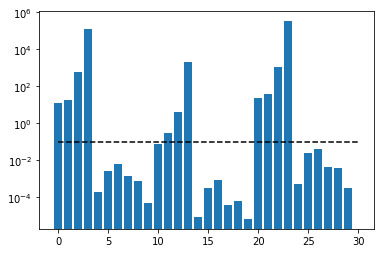

In [ ]:
X, y = datasets.load_breast_cancer(return_X_y=True)

threshold = 0.1
vt = VarianceThreshold(threshold)
X_vt = vt.fit_transform(X)

print('# vars original: {0}, # vars com threshold: {1}'.format(X.shape[1], X_vt.shape[1]))

fig, ax = plt.subplots()
ax.bar(range(len(vt.variances_)), vt.variances_)
ax.set_yscale('log')
ax.plot([0, len(vt.variances_)], [threshold, threshold], "k--")

print(vt.variances_)

### Técnica 2: Teste Chi^2

Calculamos a dependência entre cada variável e as classes de acordo com o teste Chi^2, para atribuir um _score_ de relevância às variáveis. Utilizamos o teste Chi^2 com a classe SelectKBest, que irá selecionar as k melhores variáveis. No nosso caso, escolhemos k=10.

[Referência](https://en.wikipedia.org/wiki/Chi-squared_test) do teste Chi^2


In [ ]:
skb_c = SelectKBest(chi2, k=10)
X_chi = skb_c.fit_transform(X, y)

print('Variáveis selecionadas com Chi^2:', get_vars(X, skb_c.get_support()))

Variáveis selecionadas com Chi^2: [0, 1, 2, 3, 12, 13, 20, 21, 22, 23]


### Técnica 3: Informação Mútua

Calculamos a dependência entre cada variável e as classes utilizando a métrica de informação mútua, para então atribuir um _score_ de relevância às variáveis. Novamente utilizamos a classe SelectKBest, que irá selecionar as k melhores variáveis, com k=10.

[Referência](https://en.wikipedia.org/wiki/Mutual_information) de Informação Mútua

In [ ]:
skb_m = SelectKBest(mutual_info_classif, k=10)
X_mi = skb_m.fit_transform(X, y)

print('Variáveis selecionadas com MI:', get_vars(X, skb_c.get_support()))

Variáveis selecionadas com MI: [0, 1, 2, 3, 12, 13, 20, 21, 22, 23]


Depois de aplicar as transformações, temos 3 novos conjuntos de dados. Note que as variáveis escolhidas em cada caso é diferente.

### Exemplo completo

Vamos ver como a seleção de variáveis altera o resultado do treinamento de modelos, só que utilizando um dataset maior:

In [ ]:
#Carga do dataset BANK
df = pd.read_csv('data/tab_bank.csv', sep=';')

y = df['y']
y = np.array(y == 'yes').astype('uint8')

df = df.drop(['y'], axis=1)
df = pd.get_dummies(df)
X = np.array(df)

#Split dos dados em train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=420)

#Rescaling dos dados para o intervalo [0,1]
scaler = MinMaxScaler()
scaler.fit(X_train)

X_train_s = scaler.transform(X_train)
X_test_s = scaler.transform(X_test)

FileNotFoundError: ignored

In [ ]:
#Treinamento do modelo inicial

n_vars = X.shape[1]

print('####################################################')
print('Baseline (sem seleção de variáveis)')
print('____________________________________________________')
acc = run_lr(X_train_s, X_test_s, y_train, y_test)
print('Acc (baseline, %d vars): %f' % (n_vars, acc))

#Treinamento do modelo usando variância para selecionar variáveis
#Utilizamos diferentes valores de variância para tentar encontrar o melhor
print('####################################################')
print('Seleção com variância')

for threshold in [0.05, 0.1, 0.2, 0.3, 0.5]:
    vt = VarianceThreshold(threshold)

    t0 = perf_counter()
    X_train_vt = vt.fit_transform(X_train)
    t1 = perf_counter() - t0
    
    X_test_vt = vt.transform(X_test)
    
    n_vars_vt = X_train_vt.shape[1]
    acc_vt = run_lr(X_train_vt, X_test_vt, y_train, y_test)
    print('____________________________________________________')
    print('Acc (variância > %f, %d vars): %f - %f s' % (threshold, n_vars_vt, acc_vt, t1),' - Variáveis: ', get_vars(X_train, vt.get_support()))
    

In [ ]:
#Treinamento do modelo usando Chi^2 para selecionar variáveis
#Utilizamos diferentes valores de k para tentar encontrar o melhor
print('####################################################')
print('Seleção com Chi^2')

for k in [3, 5, 7, 10, 20, 30, 40]:
    skb_c = SelectKBest(chi2, k=k)
    
    t0 = perf_counter()
    X_train_chi = skb_c.fit_transform(X_train_s, y_train)
    t1 = perf_counter() - t0
    
    X_test_chi = skb_c.transform(X_test_s)

    acc_chi = run_lr(X_train_chi, X_test_chi, y_train, y_test)
    print('____________________________________________________')
    print('Acc (Chi^2, %d vars): %f - %f s' % (k, acc_chi, t1), ' - Variáveis: ', get_vars(X_train, skb_c.get_support()))

In [ ]:
#Treinamento do modelo usando Informação Mútua para selecionar variáveis
#Utilizamos diferentes valores de k para tentar encontrar o melhor
print('####################################################')
print('Seleção com Informação Mútua')

for k in [3, 5, 7, 10, 20, 30, 40]:
    skb_m = SelectKBest(mutual_info_classif, k=k)
    
    t0 = perf_counter()
    X_train_mi = skb_m.fit_transform(X_train_s, y_train)
    t1 = perf_counter() - t0
    
    X_test_mi = skb_m.transform(X_test_s)
    acc_mi = run_lr(X_train_mi, X_test_mi, y_train, y_test)
    print('____________________________________________________')
    print('Acc (MI, %d vars): %f - %f s' % (k, acc_mi, t1), ' - Variáveis: ', get_vars(X_train, skb_m.get_support()))

### Como interpretar esses resultados?

1. Seleção de variáveis baseada em dadois não funciona, pois a acurácia diminuiu.
2. Seleção de variáveis baseada em dados funciona, pois conseguimos obter quase a mesma acurácia com uma fração muito menor de variáveis.

O que você acha? Quais os pontos fortes e fracos dessa abordagem, em geral?

________________________________________________________________________________________________________________

## Seleção de Variáveis baseada em Modelos

Na abordagem baseada em modelos, treinamos diversos modelos com conjuntos diferentes de variáveis para determinar qual o mais apropriado para o problema em questão. Há várias formas de se fazer isso, e mostraremos três aqui:

### Técnica 1: _Eliminação_ Recursiva de Atributos

Vários modelos fornecem informação de importância de cada variável após o treinamento. Com base nessa informação, podemos treinar o modelo várias vezes e eliminar as variáveis menos importantes a cada treinamento.

In [ ]:
#Carga do dataset BANK
df = pd.read_csv('datasets/tab_bank.csv', sep=';')

y = df['y']
y = np.array(y == 'yes').astype('uint8')

df = df.drop(['y'], axis=1)
df = pd.get_dummies(df)
X = np.array(df)

#Split dos dados em train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=420)

#Rescaling dos dados para o intervalo [0,1]
scaler = MinMaxScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

FileNotFoundError: ignored

In [ ]:
print('####################################################')
print('Eliminação Recursiva de Atributos')
print('____________________________________________________')


rfecv_lr = RFECV(LogisticRegression(solver='liblinear'), step=1, min_features_to_select=1, cv=5, scoring='accuracy', n_jobs=4)

t0 = perf_counter()
rfecv_lr.fit(X_train, y_train)
t1 = perf_counter() - t0

y_pred = rfecv_lr.predict(X_test)
acc_rfe_lr = accuracy_score(y_test, y_pred)

print('Acc (RFE(LR), %d vars): %f - %f s' % (rfecv_lr.n_features_, acc_rfe_lr, t1), ' - Variáveis: ', get_vars(X_train, rfecv_lr.get_support()))

### Técnica 2: _Seleção_ Sequencial de Atributos (incremental)

Neste caso, partimos de uma variável, e vamos acrescentando outras até o valor $k$, de modo a obter o melhor conjunto de variáveis possível para o modelo.

Há uma diferença importante desse método em relação aos demais: ele não requer que o modelo forneça informação de relevância das variáveis: a relevância é obtida com base na acurácia obtida nos treinamentos sucessivos com diferentes combinações de variáveis.

In [ ]:
#Treinamento do modelo usando Seleção Sequencial de Atributos (Incremental)
#Utilizamos diferentes valores de k para tentar encontrar o melhor
print('####################################################')
print('Seleção Sequencial de Atributos (Incremental)')

for k in [1, 3, 5, 7, 10, 20, 30, 40]:
    sfs_fwd = SequentialFeatureSelector(LogisticRegression(solver='liblinear'), n_features_to_select=k, scoring='accuracy', direction='forward', n_jobs=16)
    
    t0 = perf_counter()
    sfs_fwd.fit(X_train, y_train)
    t1 = perf_counter() - t0
    
    X_train_sfs_fwd = sfs_fwd.transform(X_train)
    X_test_sfs_fwd = sfs_fwd.transform(X_test)
    acc_sfs_fwd = run_lr(X_train_sfs_fwd, X_test_sfs_fwd, y_train, y_test)

    print('____________________________________________________')
    print('Acc (SFS(fwd), %d vars): %f - %f s' % (k, acc_sfs_fwd, t1), ' - Variáveis: ', get_vars(X_train, sfs_fwd.get_support()))


### Técnica 2: _Seleção_ Sequencial de Atributos (decremental)

Neste caso, iniciamos com _todas_ as variáveis, e vamos removendo as menos importantes até obter $k$ variáveis.

Novamente, este método só depende da acurácia do modelo.

In [ ]:
#Treinamento do modelo usando Seleção Sequencial de Atributos (Decremental)
#Utilizamos diferentes valores de k para tentar encontrar o melhor
print('####################################################')
print('Seleção Sequencial de Atributos (Decremental)')

for k in [1, 3]: #, 5, 7, 10, 20, 30, 40]: #comentado porque demora muito
    sfs_bwd = SequentialFeatureSelector(LogisticRegression(solver='liblinear'), n_features_to_select=k, scoring='accuracy', direction='backward', n_jobs=16)
    
    t0 = perf_counter()
    sfs_bwd.fit(X_train, y_train)
    t1 = perf_counter() - t0
    
    X_train_sfs_bwd = sfs_bwd.transform(X_train)
    X_test_sfs_bwd = sfs_bwd.transform(X_test)
    acc_sfs_bwd = run_lr(X_train_sfs_bwd, X_test_sfs_bwd, y_train, y_test)

    print('____________________________________________________')
    print('Acc (SFS(bwd), %d vars): %f - %f s' % (k, acc_sfs_bwd, t1), ' - Variáveis: ', get_vars(X_train, sfs_bwd.get_support()))
